## Airbnb DC Hosting Helper ##

## 8_extra_practice_with_PCA ## 

### Summary ###

This notebook will be adding on PCA to the the final extra trees model to see if this method of feature reduction can improve the model precision scores even more.

Import libraries.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import resample
from sklearn.decomposition import PCA 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay

In [36]:
np.random.seed(100)

In [37]:
pd.set_option('display.max_columns', 300)

In [38]:
pd.set_option('display.max_rows', 300)

Read in data and prepare for modeling by dropping unnecessary columns.

In [39]:
df = pd.read_csv('../data/final_df.csv')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 100 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                3652 non-null   int64  
 1   id                                        3652 non-null   int64  
 2   name                                      3652 non-null   object 
 3   description                               3609 non-null   object 
 4   neighborhood_overview                     2794 non-null   object 
 5   host_id                                   3652 non-null   int64  
 6   host_about                                2529 non-null   object 
 7   host_response_time                        3652 non-null   object 
 8   host_response_rate                        3652 non-null   float64
 9   host_acceptance_rate                      3652 non-null   float64
 10  host_is_superhost                  

In [41]:
df.drop(columns = ['Unnamed: 0', 'id', 'host_id',  'amenities', 'latitude_x', 'longitude_x',
                   'name', 'description', 'neighborhood_overview', 'host_about'
                  ], inplace=True)

Make all columns in snake case below.

In [42]:
cols = df.columns

new_cols = []

for i in cols:
    new_cols.append(i.replace(' ','_'))

In [43]:
df.columns = new_cols

In [44]:
df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,instant_bookable,calculated_host_listings_count,historic_site,museum,metro,music_venue,perfomring_arts_venue,college_and_university,food,nightlife_spot,outdoors_and_recreation,government_building,clothing_store,popular,days_being_host,days_since_first_review,days_since_last_review,name_word_count,name_neutral_sentiment,name_negative_sentiment,name_positive_sentiment,name_compound_sentiment,description_word_count,description_neutral_sentiment,description_negative_sentiment,description_positive_sentiment,description_compound_sentiment,neighborhood_overview_word_count,neighborhood_overview_neutral_sentiment,neighborhood_overview_negative_sentiment,neighborhood_overview_positive_sentiment,neighborhood_overview_compound_sentiment,host_about_word_count,host_about_neutral_sentiment,host_about_negative_sentiment,host_about_positive_sentiment,host_about_compound_sentiment,wifi,smoke_alarm,essentials,heating,air_conditioning,hangers,iron,kitchen,long_term_stays_allowed,hair_dryer,carbon_monoxide_alarm,hot_water,shampoo,dedicated_workspace,dishes_and_silverware,microwave,washer,dryer,fire_extinguisher,refrigerator,coffee_maker,cooking_basics,private_entrance,bed_linens,stove,oven,free_street_parking,dishwasher,first_aid_kit,extra_pillows_and_blankets,tv,patio_or_balcony
0,within a day,0.8,0.75,0,1,1,Historic Anacostia,Private room,1,1.0,1.0,1.0,55.0,2,365,2.0,365.0,1,31,61,336,0,2,1,2,1,0,3,10,25,5,28,21,5,0,4610,2576,180,3,1.000,0.0,0.000,0.0000,164,0.867,0.016,0.117,0.9230,25,0.846,0.000,0.154,0.6369,180,0.818,0.000,0.182,0.9828,1,1,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,0,1
1,within an hour,1.0,0.93,0,1,1,"Spring Valley, Palisades, Wesley Heights, Foxh...",Entire home/apt,2,1.0,1.0,2.0,97.0,7,200,7.0,1125.0,9,20,50,140,0,43,2,1,0,0,1,40,18,4,29,6,0,1,4437,1912,16,6,0.325,0.0,0.675,0.8519,169,0.828,0.000,0.172,0.9806,157,0.823,0.029,0.148,0.9657,210,0.801,0.006,0.192,0.9911,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,0
2,within a day,1.0,0.35,0,1,1,"Dupont Circle, Connecticut Avenue/K Street",Entire home/apt,4,1.0,1.0,2.0,185.0,2,180,2.0,180.0,17,47,76,76,0,2,36,28,2,15,46,44,50,50,45,48,47,0,4346,2223,19,4,0.455,0.0,0.545,0.5574,174,0.884,0.000,0.116,0.9686,117,0.914,0.000,0.086,0.7750,53,0.748,0.000,0.252,0.9260,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,0,1
3,within an hour,1.0,1.00,0,1,1,"Cathedral Heights, McLean Gardens, Glover Park",Entire home/apt,4,1.0,1.0,3.0,125.0,1,365,1.0,1125.0,12,42,72,347,1,4,5,0,0,1,4,17,48,27,44,24,2,0,4347,3929,23,3,1.000,0.0,0.000,0.0000,193,0.880,0.067,0.053,-0.5788,176,0.837,0.008,0.155,0.9826,141,0.836,0.000,0.164,0.9689,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1
4,within an hour,1.0,1.00,0,1,1,"Cathedral Heights, McLean Gardens, Glover Park",Private room,2,1.5,1.0,1.0,61.0,1,365,1.0,1125.0,19,49,79,354,1,4,5,0,0,1,4,17,48,27,44,24,2,0,4347,2121,28,4,1.000,0.0,0.000,0.0000,185,0.775,0.049,0.177,0.9800,81,0.740,0.040,0.220,0.9435,141,0.836,0.000,0.164,0.9689,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1


One hot encode variables.

In [45]:
normal = df.drop(columns=  ['host_response_time', 'neighbourhood_cleansed', 'room_type'])

ohe_cats = ['host_response_time', 'neighbourhood_cleansed', 'room_type']

categorical = df[ohe_cats]

In [46]:
enc = OneHotEncoder(drop = 'first', sparse=False)

categorical = enc.fit_transform(categorical) 

In [47]:
dummy_cat_names = enc.get_feature_names(ohe_cats)

categorical_df = pd.DataFrame(categorical, columns=dummy_cat_names)

In [48]:
df = pd.concat([normal, categorical_df], axis=1)

In [49]:
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,instant_bookable,calculated_host_listings_count,historic_site,museum,metro,music_venue,perfomring_arts_venue,college_and_university,food,nightlife_spot,outdoors_and_recreation,government_building,clothing_store,popular,days_being_host,days_since_first_review,days_since_last_review,name_word_count,name_neutral_sentiment,name_negative_sentiment,name_positive_sentiment,name_compound_sentiment,description_word_count,description_neutral_sentiment,description_negative_sentiment,description_positive_sentiment,description_compound_sentiment,neighborhood_overview_word_count,neighborhood_overview_neutral_sentiment,neighborhood_overview_negative_sentiment,neighborhood_overview_positive_sentiment,neighborhood_overview_compound_sentiment,host_about_word_count,host_about_neutral_sentiment,host_about_negative_sentiment,host_about_positive_sentiment,host_about_compound_sentiment,wifi,smoke_alarm,essentials,heating,air_conditioning,hangers,iron,kitchen,long_term_stays_allowed,hair_dryer,carbon_monoxide_alarm,hot_water,shampoo,dedicated_workspace,dishes_and_silverware,microwave,washer,dryer,fire_extinguisher,refrigerator,coffee_maker,cooking_basics,private_entrance,bed_linens,stove,oven,free_street_parking,dishwasher,first_aid_kit,extra_pillows_and_blankets,tv,patio_or_balcony,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,"neighbourhood_cleansed_Brookland, Brentwood, Langdon","neighbourhood_cleansed_Capitol Hill, Lincoln Park","neighbourhood_cleansed_Capitol View, Marshall Heights, Benning Heights","neighbourhood_cleansed_Cathedral Heights, McLean Gardens, Glover Park","neighbourhood_cleansed_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","neighbourhood_cleansed_Colonial Village, Shepherd Park, North Portal Estates","neighbourhood_cleansed_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","neighbourhood_cleansed_Congress Heights, Bellevue, Washington Highlands","neighbourhood_cleansed_Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights","neighbourhood_cleansed_Douglas, Shipley Terrace","neighbourhood_cleansed_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street","neighbourhood_cleansed_Dupont Circle, Connecticut Avenue/K Street","neighbourhood_cleansed_Eastland Gardens, Kenilworth","neighbourhood_cleansed_Edgewood, Bloomingdale, Truxton Circle, Eckington","neighbourhood_cleansed_Fairfax Village, Naylor Gardens, Hillcrest, Summit Park","neighbourhood_cleansed_Friendship Heights, American University Park, Tenleytown","neighbourhood_cleansed_Georgetown, Burleith/Hillandale","neighbourhood_cleansed_Hawthorne, Barnaby Woods, Chevy Chase",neighbourhood_cleansed_Historic Anacostia,"neighbourhood_cleansed_Howard University, Le Droit Park, Cardozo/Shaw","neighbourhood_cleansed_Ivy City, Arboretum, Trinidad, Carver Langston","neighbourhood_cleansed_Kalorama Heights, Adams Morgan, Lanier Heights","neighbourhood_cleansed_Lamont Riggs, Queens Chapel, Fort Totten, Pleasant Hill","neighbourhood_cleansed_Mayfair, Hillbrook, Mahaning Heights","neighbourhood_cleansed_Near Southeast, Navy Yard","neighbourhood_cleansed_North Cleveland Park, Forest Hills, Van Ness","neighbourhood_cleansed_North Michigan Park, Michigan Park, University Heights","neighbourhood_cleansed_River Terrace, Benning, Greenway, Dupont Park","neighbourhood_cleansed_Shaw, Logan Circle","neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista","neighbourhood_cleansed_Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point","neighbourhood_cleansed_Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Villa

In [50]:
df.shape

(3652, 132)

The baseline score is 78%.

In [51]:
df['popular'].value_counts(normalize=True)

0    0.776835
1    0.223165
Name: popular, dtype: float64

The best predictive model with oversampling minority class and extra trees is show below. I have included random state variables in these models for reproducable results. 

In [52]:
X = df.drop(columns=['popular'])
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=100 )

In [53]:
X_sample = pd.concat([X_train, y_train], axis=1)

popular = X_sample[X_sample['popular']==1]

not_popular = X_sample[X_sample['popular']==0]

In [54]:
popular_sample = resample(popular, replace=True, n_samples=len(not_popular))

In [55]:
updated_sample = pd.concat([not_popular, popular_sample])

In [56]:
updated_sample['popular'].value_counts()

0    2128
1    2128
Name: popular, dtype: int64

In [57]:
X_train = updated_sample.drop(columns=['popular'])

y_train = updated_sample['popular']

Scale data before performing PCA.

In [58]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [59]:
pca = PCA(random_state=42)

In [60]:
Z_train = pca.fit_transform(X_train_sc)

In [61]:
Z_test = pca.transform(X_test_sc)

See the cumulative variance explained through the PCA components

In [63]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance through all components: {np.round(cum_var_exp[:132],3)}')

Cumulative explained variance through all components: [0.064 0.126 0.159 0.189 0.217 0.241 0.264 0.285 0.304 0.322 0.34  0.356
 0.371 0.384 0.397 0.409 0.421 0.433 0.444 0.455 0.466 0.476 0.486 0.497
 0.507 0.516 0.526 0.535 0.544 0.553 0.562 0.571 0.58  0.588 0.597 0.605
 0.613 0.622 0.63  0.638 0.646 0.654 0.662 0.67  0.678 0.685 0.693 0.701
 0.709 0.716 0.724 0.732 0.739 0.747 0.754 0.761 0.769 0.776 0.783 0.79
 0.797 0.804 0.811 0.817 0.824 0.83  0.837 0.843 0.849 0.854 0.86  0.865
 0.871 0.876 0.881 0.886 0.891 0.896 0.901 0.906 0.91  0.915 0.919 0.924
 0.928 0.932 0.936 0.939 0.943 0.947 0.95  0.953 0.957 0.96  0.963 0.966
 0.968 0.971 0.974 0.976 0.978 0.98  0.982 0.984 0.986 0.988 0.99  0.991
 0.993 0.994 0.995 0.997 0.998 0.998 0.999 0.999 1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]


From the cumulative sums above, I can see that the features together incrementally explain more variance in the model so keeping almost the max number of components makes sense. My initial fit transform with PCA is good to keep.

Fit extra tress model below.

In [64]:
et = ExtraTreesClassifier(random_state=100)

et.fit(Z_train, y_train)

predictions = et.predict(Z_test)

print(f'training accuracy score: {et.score(Z_train, y_train)}')

print(f'testing accuracy score: {et.score(Z_test, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.7951807228915663
testing f1 score: 0.1904761904761905
testing precision score: 0.8148148148148148
testing recall score: 0.10784313725490197


The evaluation metrics for the best predictive model are shown in the printouts above and below. The accuracy score for the testing data is 80% and the precision score is 81%, which both beat the baseline of 77% with unbalanced classes. 

In [65]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       709
           1       0.81      0.11      0.19       204

    accuracy                           0.80       913
   macro avg       0.80      0.55      0.54       913
weighted avg       0.80      0.80      0.73       913



In the classification report above, we can see how preicision has been optimized for both classes. 

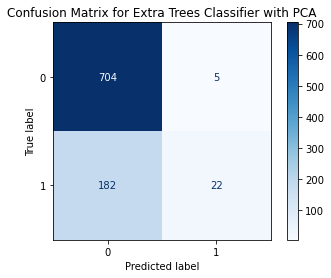

In [66]:
cm = confusion_matrix(y_test, predictions)

ConfusionMatrixDisplay(cm, display_labels=et.classes_).plot(cmap='Blues');

plt.title('Confusion Matrix for Extra Trees Classifier with PCA');

Similarly, in the confusion matrix above we can see how precision has been optimized. There are fewer cases where a listing is being categorized as popular if it is not, compared to a listing be classified as not popular but it is. This will help us to not convey false results about popularity predictions to our audience. 

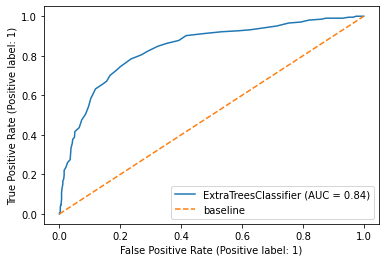

In [67]:
plot_roc_curve(et, Z_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = 'baseline', linestyle='--')

# add a legend
plt.legend();

The ROC curve above can show us how much overlap there is between the distribution of our classes popular and not popular. The area under the ROC curve is .84, which shows a very strong division of our classes. 

Below, I wanted to look at the featues that are the most imporant in this model. 

In [68]:
sorted(set(zip(et.feature_importances_, X.columns)), reverse=True)

[(0.02451727278811674, 'host_response_rate'),
 (0.023203994219645217, 'host_has_profile_pic'),
 (0.019505507906003777, 'price'),
 (0.014499647632477993, 'historic_site'),
 (0.01414323536234248, 'host_identity_verified'),
 (0.013927155476833845, 'host_is_superhost'),
 (0.013383281212753083, 'dishwasher'),
 (0.013271338150486763,
  'neighbourhood_cleansed_Capitol View, Marshall Heights, Benning Heights'),
 (0.01269796355949928, 'accommodates'),
 (0.012515206705398576, 'host_acceptance_rate'),
 (0.011709130569736444, 'oven'),
 (0.01097697323517135, 'host_response_time_within a few hours'),
 (0.010637729013694246, 'availability_30'),
 (0.010618814100925567, 'iron'),
 (0.01035138462631129, 'neighbourhood_cleansed_Brookland, Brentwood, Langdon'),
 (0.010309611248052724, 'neighbourhood_cleansed_Eastland Gardens, Kenilworth'),
 (0.009680190097893362,
  'neighbourhood_cleansed_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View'),
 (0.009522573021739388,
  'neighbourhood_cleansed_Downtow

The feature importances are very similar to the output of logistic regression coefficients. It appears that now the response rate, profile picture, and price are very important to being considered popular.